# Set up dependencies and imports

Day 2 is meant to dive deeper into more advanced techniques of how to improve your model performance from day 1. We hope that you'll be able to adapt some of these ideas into your code from day 1. These have largely been inspired by techniques from the [Bag of Tricks for Image Classification with CNNs](https://arxiv.org/abs/1812.01187), as well as some others from FastAI. 



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchvision.datasets import MNIST

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import math

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
random_seed = 64
batch_size = 8

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try: print(torch.cuda.get_device_name(0))
except: print(device)

Tesla T4


# Convolution in Pytorch

You might have been wondering how exactly to implement a convolution operation described in the slides...fortunately, pytorch provides us with mostly ready in-built convolutional layers that we can add to use to build our model. Similar to the linear layers, convolutional layers from from the nn Module of pytorch. The link to the documentation has been provided below. 

https://pytorch.org/docs/stable/nn.html#convolution-layers

For our specific use case, we will be using the conv2d module. This means that the convolution takes place in only 2 axes, along the height and width of the image. You should notice from the documentation that there are also conv1d and conv3d layers; do you know how they work and what's the difference between them and the 2d version?

Additionally, take note of the most important variable to change when applying the conv2d layer: the number of channels. In channels refers to the number of channels in the input tensor and out channels refers to the number of channels in the output tensor after passing through the layer. For example, the first conv2d layer of your model should have a in_channels of 3 since there are 3 color channels, and out_channels is some integer of your choice; if you choose 32 for example, this means that you apply **32 different** convolutional filters on the image to yield an output of shape 32 x H x W. 

Other hyperparameters include the kernel size (3 is usually used) and padding (the right amount of padding is usually used to ensure that the height and width dimensions remain the same in the output - why?).

In [4]:
kernel_size = 3
stride = 1
# formula for 'same' padding is always kernel_size floor divide 2
padding = kernel_size // 2

# next we create a convolution layer for us to play with
layer = nn.Conv2d(in_channels=3, 
                  out_channels=32, 
                  kernel_size=kernel_size, 
                  padding=padding, 
                  stride=stride)

# Now that we have our conv layer, let's create some dummy input to feed into the layer
# Conv2d always takes in a 4D input, read the docs for more info
test_input = torch.randn((1, 3, 256, 256))
output = layer(test_input)
output.shape

torch.Size([1, 32, 256, 256])

Try using different parameters to and see what happens to the shape of the output

In [5]:
#@title Default title text
kernel_size =  3#@param {type:"integer"}
stride =  1#@param {type:"integer"}
# formula for 'same' padding is always kernel_size floor divide 2
padding = kernel_size // 2

# next we create a convolution layer for us to play with
layer = nn.Conv2d(in_channels=3, 
                  out_channels=32, 
                  kernel_size=kernel_size, 
                  padding=padding, 
                  stride=stride)

# Now that we have our conv layer, let's create some dummy input to feed into the layer
# Conv2d always takes in a 4D input, read the docs for more info
test_input = torch.randn((1, 3, 256, 256))
output = layer(test_input)
output.shape

torch.Size([1, 32, 256, 256])

# Normalisation

Consider a set of random samples {1, 2, 3, 4}  
To normalise this, we would want to rescale each element according to the variance of the whole set  
We would also want to shift the elements so that they are centered around the mean

Hence for each x in {1, 2, 3, 4}  
The normalised form would be 
>$\sqrt{\frac{x-2.5}{1.291}}$  
or  
>$\sqrt{\frac{x-\mu}{\sigma}}$

In [6]:
def norm(arr, mode="population"):
    mu = sum(arr)/len(arr)
    if (mode == "population"):
        x2 = sum([i**2 for i in arr])/len(arr)
        var = x2 - mu**2
    elif (mode == "sample"):
        var = sum([(i-mu)**2 for i in arr])/(len(arr)-1)
    else:
        return None

    return mu, var, var**0.5

mean, var, stddev = norm([1, 2, 3, 4], mode="population")
print(f"mean {mean}\nvariance {var}\nstddev {stddev}")

mean 2.5
variance 1.25
stddev 1.118033988749895


However, notice that the stddev calculated is different from the example above.  
This is becase we are using the formula for population variance.  
It is important to know that variance in most deeplearning frameworks are calculated as the sample variance, since the population distrubution for your data will always be unknown

##BatchNorm

Batch norm is a fairly simple way to normalise the data at any given layer  
The formula is as follows
>$y_i = \frac{x_i-\mathrm{E}(X)}{\sqrt{\mathrm{Var}(X) + \epsilon}}\times\gamma+\beta$  
Where $\gamma$ and $\beta$ are trainable parameters and $\epsilon$ is just to prevent division by 0

In [7]:
bn1d = nn.BatchNorm1d(num_features=4, momentum=0.1, affine=False) # creating a new batchnorm layer
testInput = torch.randn(2, 4)
testInput = [[1.0, 2.0, 3.0, 4.0]]*2
testInput = torch.tensor(testInput)
bn1d(testInput)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])

Notice how when using torch.randn to generate testInput, the result are all almost $\pm1$  
This is because torch.randn is generated using a distribution with $\mu = 0$ and and $\sigma = 1$

In [8]:
testInput = [[[1.0, 2.0, 3.0, 4.0]]*4]
testInput = torch.tensor(testInput)
bn1d(testInput)

tensor([[[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]]])

Note that batchnorm generally requires high dimensionality (many samples and many features) to work well. Hence it's generally not very useful unless you have a god tier gpu

**DONT DOUBLE CLICK THIS CELL**  
As the name implies, batchnorm normalises over the batch of data.  
Other types of normalisation include:  

*   Layer Norm - Normalisation over all pixels/features for all channels
*   Instance Norm - Normalisation over all pixels/features for 1 channel
*   Group Norm - Normalisation over all pixels/features for a few channels


Refer to image below  
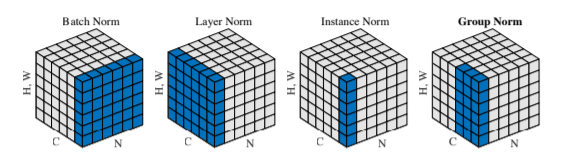

Now notice that entire chunks are being converted to 0 randomly when running dropout2d. This is a feature of a 2d dropout, where instead of sampling individual elements, channels (last dimension) are sampled instead

#Residual Connections

Residual connections has been and still is one of the most seminal advancements in the deep learning CV field over the past few years. The following class implements a residual block made up of 3 basic building blocks: a conv2d layer, a normalization layer (layerNorm in this case), and an activation function (RELU here). 

In addition to all that, we have a skip connections that adds the input to the output of 2 residual blocks down. 

In [9]:
# replace this section with your own model
# Note that this model has a reshaping issue, try debugging it
class helloworld(nn.Module):
    # constructor statement that will be used to create new instances of your model object
    def __init__(self, layers, input_channels, hidden_channels, output_dim, kernel):
        super(helloworld, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.output_dim = output_dim

        # create the layers
        self.input_layer = nn.Conv2d(input_channels, hidden_channels, kernel_size, stride=2, padding=1)
        block = nn.Sequential(nn.Conv2d(hidden_channels, hidden_channels, kernel, padding=1), # you can use nn.Sequential to group layers together
                              nn.ReLU(),
                              nn.BatchNorm2d(hidden_channels),
                              nn.Dropout(0.5),
                              nn.Conv2d(hidden_channels, hidden_channels, kernel, padding=1), # you can use nn.Sequential to group layers together
                              nn.ReLU(),
                              nn.BatchNorm2d(hidden_channels),
                              nn.Dropout(0.5))
        hidden_blocks = []
        for i in range(layers):
            hidden_blocks.append(block)
        self.hidden_layers = nn.ModuleList(hidden_blocks) # google python args to understand what the * is for
        self.output_layer = nn.Sequential(nn.Linear(1960, output_dim),
                                          nn.Softmax())

    # the forward pass method that will be used for everything
    def forward(self, input):
        x = self.input_layer(input)
        
        # this is where the skip connection happens
        for block in self.hidden_layers:
            x = block(x) + x # literally just this part
        x = x.flatten(start_dim = 1)
        x = self.output_layer(x)

        return x

Try to find the issue in this model  
HINT: is the input to the linear layer really of shape (10) ?

In [10]:
model = helloworld(2, 5, 10, 2, 3)

In [11]:
print(model)

helloworld(
  (input_layer): Conv2d(5, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): BatchNorm2d(10, eps=1e-05, momentum=0.1,

In [12]:
# try feeding this into the model
test_in = torch.randn(1, 5, 28, 28)
model(test_in)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.2299, 0.7701]], grad_fn=<SoftmaxBackward>)

Now then, there's another problem with this model.  

Yesterday we had a model that had too many parameters because of the linear layer  

Is there anything we can do at the conv2d layers so that the input to the Linear layer is of a smaller size?

In [13]:
# instantiate a model suitable for the planet dataset and try to feed one of the images in

# Instantiate model

In [14]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms
from torch import Tensor
from collections import Counter
from pandas import DataFrame
from math import ceil
import random 
import numpy as np
import torch 
import pandas as pd 
import os

In [15]:
%%shell

cp -r '.../*' .
unzip train.zip -d /content

cp: cannot stat '.../*': No such file or directory
Archive:  train.zip
  inflating: /content/train/train_10019.jpg  
  inflating: /content/train/train_10027.jpg  
  inflating: /content/train/train_10069.jpg  
  inflating: /content/train/train_10071.jpg  
  inflating: /content/train/train_10132.jpg  
  inflating: /content/train/train_1015.jpg  
  inflating: /content/train/train_10226.jpg  
 extracting: /content/train/train_10239.jpg  
  inflating: /content/train/train_10240.jpg  
  inflating: /content/train/train_10250.jpg  
  inflating: /content/train/train_10270.jpg  
  inflating: /content/train/train_10297.jpg  
  inflating: /content/train/train_10310.jpg  
  inflating: /content/train/train_10344.jpg  
  inflating: /content/train/train_10364.jpg  
  inflating: /content/train/train_10380.jpg  
  inflating: /content/train/train_10382.jpg  
  inflating: /content/train/train_10423.jpg  
  inflating: /content/train/train_10441.jpg  
  inflating: /content/train/train_10476.jpg  
  inflatin

In [16]:
# ToTensor converts the numpy array to a torch Tensor of the same data type
class ToTensor(object):
    
  def __call__(self, x: np.ndarray) -> Tensor:
    return torch.Tensor(x)

# NormalizeStandardize first normalizes the input by scaling between 0 and 1
# Then it standardizes the inputs by some given mean and std dev stats
# Lastly it reshapes the numpy array to be channels first, i.e. C X H X W
class NormalizeStandardize(object):

  def __init__(self, mean: list, std: list):
    self.mean = np.array(mean)
    self.std = np.array(std)

  def __call__(self, x: np.ndarray) -> np.ndarray:
    normalized = np.true_divide(x, 255.0)
    standardized = np.true_divide((normalized - self.mean), self.std)
    return np.transpose(standardized, axes=(2, 0, 1))

# Applies each transformation iteratively on the input
class Compose(object):

  def __init__(self, transforms: list):
    self.transforms = transforms

  def __call__(self, x: np.ndarray) -> Tensor:
    for t in self.transforms:
      x = t(x)
    return x

In [17]:
class PlanetDataset(Dataset):
    
    def __init__(self, csv_file: str,
                 img_dir: str, mapping: dict,
                 x_transforms: list=[],
                 y_transforms: list=[]):
        self.mapping = mapping
        self.labels = self.transform_labels(pd.read_csv(csv_file))
        self.img_dir = img_dir
        self.mean, self.std = self.calc_stats()
        #x_transforms.extend([NormalizeStandardize(self.mean, self.std),
        #                                                ToTensor()])
        y_transforms.append(ToTensor())
        self.x_transforms = Compose(x_transforms)
        self.y_transforms = Compose(y_transforms)

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx: int):
        img = f"{self.img_dir}/{self.labels.iloc[idx, 0]}.jpg"
        img_array = np.array(Image.open(img).convert('RGB'))
        label = self.labels.iloc[idx, 2]
        
        img_array = self.x_transforms(img_array)
        label = self.y_transforms(label)
            
        return img_array, label
    
    def visualize_images(self, num_images: int=5):
        random_selection = np.random.choice(list(self.labels['image_name']), num_images)
        cols = 1
        rows = num_images
        fig = plt.figure(figsize=(6, 6*num_images))
        for i in range(1, rows+1):
            img = f"{self.img_dir}/{random_selection[i-1]}.jpg"
            img_array = np.array(Image.open(img).convert('RGB'))
            fig.add_subplot(rows, cols, i)
            plt.axis('off')
            plt.title(f"{self.labels.loc[self.labels['image_name']==random_selection[i-1], 'tags'].iloc[0]}")
            plt.imshow(img_array)
        fig.tight_layout()
        plt.show()

    def calc_stats(self):
      image_list = os.listdir(self.img_dir)
      images = np.true_divide(np.stack([np.array(Image.open(os.path.join(self.img_dir, img)).convert('RGB')) for img in image_list]), 255.0)
      mean = np.mean(images, axis=(0, 1, 2)).reshape(1, 1, -1)
      std = np.std(images, axis=(0, 1, 2)).reshape(1, 1, -1)
      return mean, std

    def transform_labels(self, df: DataFrame):
      df['labels'] = df['tags'].apply(lambda x: self._one_hot_encode(x))
      return df

    def _one_hot_encode(self, labels: str):
      labels = labels.split(' ')
      encoding = np.zeros(len(self.mapping.keys()))
      for label in labels:
        encoding[self.mapping[label]] = 1
      return encoding

In [18]:
def count_labels(csv_file: str):
  c = Counter()
  train_csv = pd.read_csv(csv_file)
  for i in range(len(train_csv)):
    tags = train_csv['tags'][i].split(' ')
    for l in tags:
      c[l] += 1
  return c, list(c.keys())

def create_mapping(keys):
  return {key : i for i, key in enumerate(keys)}

c, keys = count_labels('train (1).csv')
mapping = create_mapping(keys)

In [19]:
ds = PlanetDataset(csv_file='train (1).csv',
                   img_dir='train',
                   mapping=mapping)

In [20]:
def train_val_split(dataset: Dataset, train_split: float):
  train_size = ceil(train_split * len(dataset))
  valid_size = len(dataset) - train_size
  train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
  return train_ds, valid_ds

train_ds, valid_ds = train_val_split(ds, 0.8)

In [21]:
class PlanetDatasetReformatted(Dataset):
    
    def __init__(self, labels_df: DataFrame,
                 img_dir: str,
                 x_transforms: list=[],
                 y_transforms: list=[],
                 stats: tuple=(None, None)):
        self.mapping = mapping
        self.labels_df = labels_df
        self.img_dir = img_dir
        self.mean, self.std = stats[0], stats[1]
        self.x_transforms, self.y_transforms = self.make_transform(x_transforms, y_transforms)
        
    def __len__(self):
        return len(self.labels_df)
        
    def __getitem__(self, idx: int):
        img = f"{self.img_dir}/{self.labels_df.iloc[idx, 0]}.jpg"
        img_array = np.array(Image.open(img).convert('RGB'))
        label = self.labels_df.iloc[idx, 2]
        img_array = self.x_transforms(img_array)
        label = self.y_transforms(label)
            
        return img_array, label
    
    def visualize_images(self, num_images: int=5):
        random_selection = np.random.choice(list(self.labels['image_name']), num_images)
        cols = 1
        rows = num_images
        fig = plt.figure(figsize=(6, 6*num_images))
        for i in range(1, rows+1):
            img = f"{self.img_dir}/{random_selection[i-1]}.jpg"
            img_array = np.array(Image.open(img).convert('RGB'))
            fig.add_subplot(rows, cols, i)
            plt.axis('off')
            plt.title(f"{self.labels_df.loc[self.labels_df['image_name']==random_selection[i-1], 'tags'].iloc[0]}")
            plt.imshow(img_array)
        fig.tight_layout()
        plt.show()

    def make_transform(self, x_transforms, y_transforms):
      if self.mean is None and self.std is None:
        self.mean, self.std = self.calc_stats()
      x_transforms.extend([NormalizeStandardize(self.mean, self.std),
                                                        ToTensor()])
      y_transforms.append(ToTensor())
      return Compose(x_transforms), Compose(y_transforms)
 
    def calc_stats(self):
      image_list = list(self.labels_df['image_name'])
      images = np.true_divide(np.stack([np.array(Image.open(os.path.join(self.img_dir, img + '.jpg')).convert('RGB')) for img in image_list]), 255.0)
      mean = np.mean(images, axis=(0, 1, 2)).reshape(1, 1, -1)
      std = np.std(images, axis=(0, 1, 2)).reshape(1, 1, -1)
      return mean, std

    def get_stats(self):
      return self.mean, self.std

In [22]:
def transform_labels(mapping: dict, df: DataFrame):
  df['labels'] = df['tags'].apply(lambda x: one_hot_encode(mapping, x))
  return df

def one_hot_encode(mapping: dict, labels: str):
  labels = labels.split(' ')
  encoding = np.zeros(len(mapping.keys()))
  for label in labels:
    encoding[mapping[label]] = 1
  return encoding

def train_val_split(csv_file: str,
                    img_dir: str,
                    mapping: dict,
                    seed: int,
                    train_split: float,
                    x_transforms: list=[],
                    y_transforms: list=[]):
  
  random.seed(seed)
  label_df = transform_labels(mapping, pd.read_csv(csv_file))
  label_df = label_df.sample(frac=1, random_state=seed).reset_index(drop=True)
  train_size = ceil(train_split * len(label_df))
  train_df, valid_df = label_df.iloc[:train_size], label_df.iloc[train_size:]
  train_ds = PlanetDatasetReformatted(labels_df=train_df,
                                      img_dir=img_dir,
                                      x_transforms=list(x_transforms),
                                      y_transforms=list(y_transforms))
  
  train_stats = train_ds.get_stats()
  valid_ds = PlanetDatasetReformatted(labels_df=valid_df,
                                      img_dir=img_dir,
                                      x_transforms=list(x_transforms),
                                      y_transforms=list(y_transforms),
                                      stats=train_stats)
  
  return train_ds, valid_ds

In [23]:
train_ds, valid_ds = train_val_split(csv_file='train (1).csv',
                                     img_dir='train',
                                     mapping=mapping,
                                     seed=42,
                                     train_split=0.8)

img, label = train_ds[0]
print(img.shape, label.shape)

torch.Size([3, 256, 256]) torch.Size([17])


In [24]:
train_dl = DataLoader(train_ds, batch_size=16,
                      shuffle=True, num_workers=4)
                      
valid_dl = DataLoader(valid_ds, batch_size=8,
                      shuffle=False, num_workers=4)

In [25]:
  x_batch, y_batch = next(iter(train_dl))
  x_batch.shape

torch.Size([16, 3, 256, 256])

In [26]:
from torch import Tensor
from functools import partial

import torch.nn.functional as F
loss_fn = F.binary_cross_entropy
# use BCE cos it is multi-label

# multi-class: many labels, but can only be 1 (e.g. only can be cow)
# multi-label: many labels, but can be many things at once (e.g. cloudy primary forest)

# Model

In [27]:
# # Code out the model class here
# from torch import nn
# class Model(nn.Module): # every class in pytorch must get from nn.Module

#     def __init__(self, layers, input_channels, hidden_channels, output_dim, kernel, input_size):
#         super(Model, self).__init__()
#         self.input_channels = input_channels
#         self.hidden_channels = hidden_channels
#         self.output_dim = output_dim

#         # create the layers
#         self.input_layer = nn.Sequential(nn.Conv2d(input_channels, input_channels, kernel, stride=2, padding=1),
#                             nn.ReLU(), nn.Conv2d(input_channels, input_channels, kernel, stride=2, padding=1),
#                             nn.ReLU(), nn.Conv2d(input_channels, hidden_channels, kernel, stride=2, padding=1))                 

#         block = nn.Sequential(nn.Conv2d(hidden_channels, hidden_channels, kernel, padding=1), # you can use nn.Sequential to group layers together
#                               nn.ReLU(),
#                               nn.Conv2d(hidden_channels, hidden_channels, kernel, padding=1), # you can use nn.Sequential to group layers together
#                               nn.ReLU(),
#                               nn.Dropout(0.3),
#                               nn.BatchNorm2d(hidden_channels))
#         hidden_blocks = []
#         for i in range(layers):
#             hidden_blocks.append(block)

#         self.hidden_layers = nn.ModuleList(hidden_blocks) # google python args to understand what the * is for
#         self.output_layer = nn.Sequential(nn.Flatten(),
#                                           nn.Linear(20480, 1000),nn.ReLU(),
#                                           nn.Linear(1000, output_dim), nn.Softmax())

#     # the forward pass method that will be used for everything
#     def forward(self, input):
#         x = self.input_layer(input)
        
#         # this is where the skip connection happens
#         for block in self.hidden_layers:
#             x = block(x) + x # literally just this part
#         #x = x.flatten(start_dim=1)
#         x = self.output_layer(x)

#         return x

In [28]:
def test_shapes(train_dataset,
                valid_dataset,
                model, 
                loss_fn):
  
  # check if there are shape issues with the data, e.g. need collating function
  train_dl = DataLoader(train_dataset, batch_size=32,
                      shuffle=True, num_workers=4)
                      
  valid_dl = DataLoader(valid_dataset, batch_size=8,
                        shuffle=False, num_workers=4)
  
  # check if there are issues with any layer in your model
  x_batch, y_batch = next(iter(train_dl))
  _, C, H, W = x_batch.shape
  num_classes = 17
  model = model(input_size=C*H*W, output_dim=num_classes)
  print(model) 
  preds = model(x_batch)

  # check if there are any issues with the labels or output
  loss = loss_fn(preds, y_batch)
  return loss.item()

In [29]:
# model = Model(layers=7, input_channels=3, hidden_channels=20, kernel=3, input_size=3*256*256, output_dim=17)
# print(model)

In [30]:
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(nn.Linear(num_ftrs, 300), nn.ReLU(), nn.Linear(300,17), nn.Softmax())
# print(model)

In [31]:
# test_shapes(train_ds,
#             valid_ds,
#             model,
#             loss_fn)

# Debugging

In [32]:
from torch import Tensor
from functools import partial
from torch.optim import Optimizer

In [33]:
def overfit_one_batch(train_dl,
                      model,
                      loss_func,
                      opt,
                      num_classes,
                      device):
  
  first_batch = next(iter(train_dl))
  _, C, H, W = first_batch[0].shape
  model = model(input_size=C*H*W, output_dim=num_classes)
  model = model.to(device)
  opt = opt(params=model.parameters())
  model.train()
  for batch_idx, (data, target) in enumerate([first_batch] * 1000):
    train_batch, labels = first_batch[0].to(device), first_batch[1].to(device)
    preds = model(train_batch)
    loss = loss_func(preds, labels)
    print(loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()

In [34]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

# # from this we can likely tell that using linear layers isn't a good strategy for images
# # oh bother, let's go ahead with training anyway
# opt = partial(torch.optim.SGD, lr=1e-2) # Import SGD optimizer directly
# num_classes = 17
# device = torch.device("cpu")
# overfit_one_batch(train_dl,
#                   model,
#                   loss_fn,
#                   opt,
#                   num_classes,
#                   device)

# Training and Evaluation

In [35]:
# better than accuracy as it accounts for precision and recall
def calc_F1(preds: Tensor, labels: Tensor, thresh: float, device):
  correct, wrong = torch.tensor([1.]).to(device), torch.tensor([0.]).to(device)
  thresholded = torch.where(preds > thresh, correct, wrong)
  confusion_matrix = thresholded / labels 
  # if labels = 1 and thresholded = 1, result is 1 (TP)
  # if labels = 1 and thresholded = 0, result is 0 (FN)
  # if labels = 0 and thresholded = 1, result is inf (FP)
  # if labels = 0 and thresholded = 0, result is nan (TN)
  TP = torch.sum(confusion_matrix == 1).item()
  FP = torch.sum(confusion_matrix == float('inf')).item()
  TN = torch.sum(torch.isnan(confusion_matrix)).item()
  FN = torch.sum(confusion_matrix == 0).item()
  precision = TP / (TP + FP + 1e-7)
  recall = TP / (TP + FN + 1e-7)
  return (2 * precision * recall) / (precision + recall + 1e-7)

def train_and_evaluate(train_dl,
                       valid_dl,
                       model,
                       opt,
                       loss_func,
                       epochs,
                       thresh,
                       device):
  
  train_history = []
  val_history = []

  for epoch in range(epochs):
    print(f"\n\nEPOCH {epoch}\n\n")
    model.train()
    for i, (train_batch, labels) in enumerate(train_dl):
      train_batch, labels = train_batch.to(device), labels.to(device)
      preds = model(train_batch)
      loss = loss_func(preds, labels)
      acc = calc_F1(preds, labels, thresh, device)
      print(f"Train Loss: {loss}    Train F1:  {acc}  at batch {i}.")
      train_history.append((loss, acc))
      opt.zero_grad() # reset gradient for very batch
      loss.backward() # calculate the gradients
      opt.step() # update the weights

    model.eval()
    with torch.no_grad(): # don't use gradient for evaluation
      for j, (val_batch, labels) in enumerate(valid_dl):
        val_batch, labels = val_batch.to(device), labels.to(device)
        preds = model(val_batch)
        loss = loss_func(preds, labels)
        acc = calc_F1(preds, labels, thresh, device)
        print(f"Valid Loss: {loss}    Valid F1:  {acc}  at batch {j}.")
        val_history.append((loss, acc))

  return train_history, val_history

In [71]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 300), nn.ReLU(), nn.Linear(300,17), nn.Sigmoid())
# print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [73]:
input_size = 3 * 256 * 256
num_classes = 17
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(train_ds, batch_size=32, shuffle=False)

train_history, val_history = train_and_evaluate(train_dl=train_dl, 
                                                valid_dl=valid_dl,
                                                model=model.to(device),
                                                opt=opt,
                                                loss_func=loss_fn,
                                                epochs=20,
                                                thresh=0.6,
                                                device=device)



EPOCH 0


Train Loss: 0.6822875142097473    Train F1:  0.01036268446402169  at batch 0.
Train Loss: 0.6365277767181396    Train F1:  0.3534482422376665  at batch 1.
Train Loss: 0.5979824662208557    Train F1:  0.43835612504326776  at batch 2.
Train Loss: 0.5740876793861389    Train F1:  0.5468749581451446  at batch 3.
Train Loss: 0.5397188663482666    Train F1:  0.6013513071174247  at batch 4.
Train Loss: 0.5092718005180359    Train F1:  0.655052219160124  at batch 5.
Train Loss: 0.47841721773147583    Train F1:  0.655290055954062  at batch 6.
Train Loss: 0.4626842141151428    Train F1:  0.63013693981282  at batch 7.
Train Loss: 0.4287951588630676    Train F1:  0.6872851760418544  at batch 8.
Train Loss: 0.41433143615722656    Train F1:  0.6537216367612436  at batch 9.
Train Loss: 0.3908299505710602    Train F1:  0.66666661950336  at batch 10.
Train Loss: 0.3690507411956787    Train F1:  0.6757678710806215  at batch 11.
Train Loss: 0.36293211579322815    Train F1:  0.6285713819863978

In [74]:
def plots(history):
  loss, acc = zip(*history)
  fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize=(20, 10))
  loss_plot.plot(loss, '-x')
  loss_plot.set(xlabel="Batch", ylabel="Loss")
  loss_plot.set_title("Loss")

  acc_plot.plot(acc, '-x')
  acc_plot.set(xlabel="Batch", ylabel="Accuracy")
  acc_plot.set_title("Accuracy")
  plt.show()

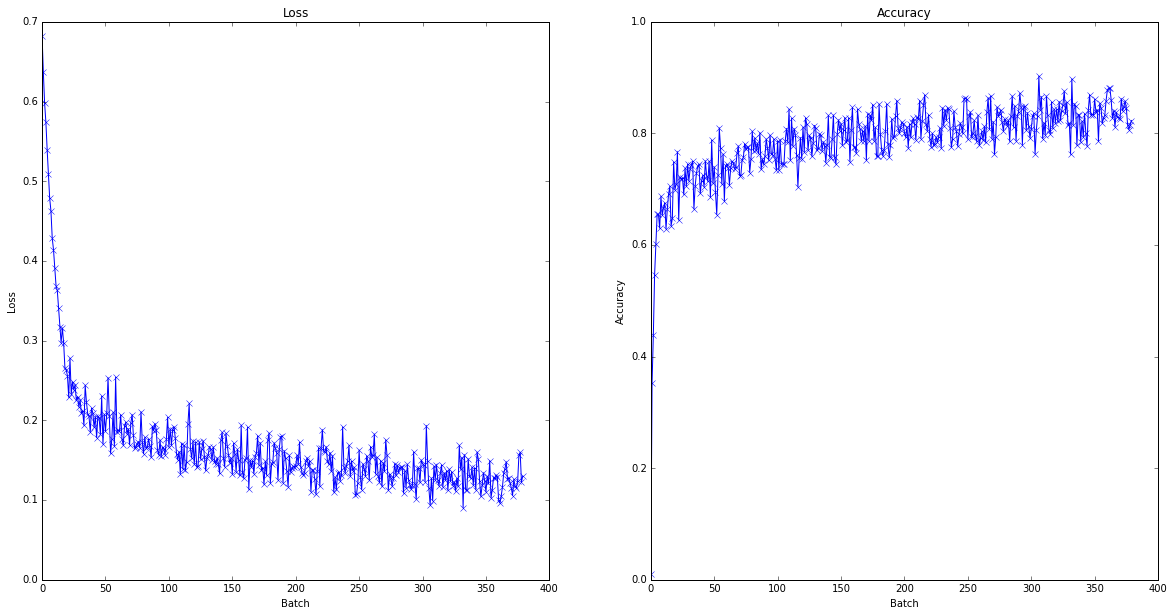

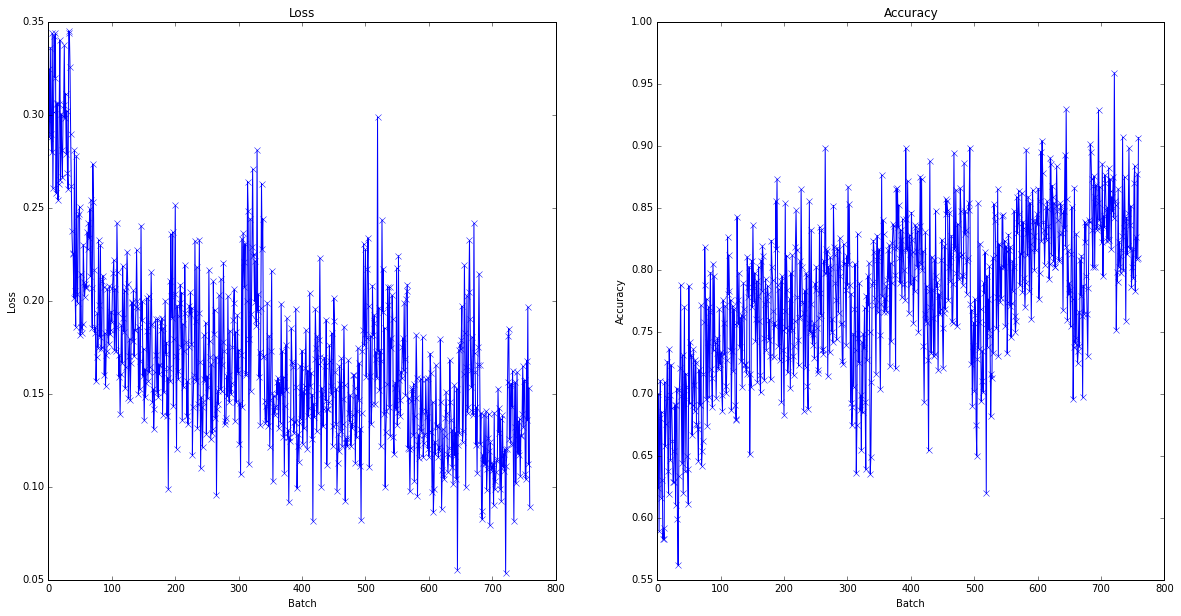

In [75]:
plots(train_history)
plots(val_history)

In [76]:
torch.save(model.state_dict(), 'resnet34_3_model.pth')

## Evaluation sample

In [ ]:
def evaluate(valid_dl,
            model,
            opt,
            loss_func,
            thresh,
            device):
  
  prediction_list = []
  model.eval()
  with torch.no_grad(): # don't use gradient for evaluation
    for j, (val_batch, labels) in enumerate(valid_dl):
      val_batch, labels = val_batch.to(device), labels.to(device)
      outputs = model(val_batch)
      print(outputs)
      prediction_list.append(outputs.tolist())
      
      # with open('/content/preds.csv','a') as fd:
      #   fd.write( ','.join(map(str, outputs.detach().tolist())) + '\n')
      # outputs = outputs > 0.4

      #_, preds = torch.max(outputs.data, 1)
    # prediction_list.append(outputs)
  return prediction_list

In [ ]:
preds = evaluate(valid_dl=valid_dl,
                          model=model.to(device),
                          opt=opt,
                          loss_func=loss_fn,
                          thresh=0.4,
                          device=device)

In [ ]:
print(preds)

In [ ]:
pred_list = []
for batch in preds:
  for tensor in batch:
    i = [i for i,x in enumerate(tensor) if x>0.4]
    pred_list.append(i)
print(pred_list)

In [ ]:
# pred_list = []
# for i in preds:
#   pred_list.append(i.tolist())
# # preds = preds.tolist()
# pred_list_2 = []
# for line in pred_list:
#   for tensor in line:
#     i = [i for i,x in enumerate(tensor) if x>0.4]
#     pred_list_2.append(i)

# print(pred_list_2)


In [ ]:
c,l = count_labels('train (1).csv')
dict1 = create_mapping(l)

import operator
sorted_dict = sorted(dict1.items(), key=operator.itemgetter(1))
print(sorted_dict)

In [ ]:
final_list = []
for line in pred_list:
  small_list = []
  for j in line:
    for i in sorted_dict:
      if i[1] == j:
        small_list.append(i[0])
  final_list.append(small_list)
print(final_list)

In [ ]:
labels = []
for i in sorted_dict:
  labels.append(i[0])
print(labels)

In [ ]:
f_list = []
for i in final_list:
  f = ' '.join(i)
  f_list.append(f)
print(f_list)

In [ ]:
import pandas as pd
df = pd.DataFrame(f_list)
df.to_csv('/content/prediction.csv')

# Drop outs

As mentioned in the slides, dropouts are a popular and generally accepted way to reduce the overfitting of a network. They are usually only applied on the last layer when transitioning from the CNN to the linear/fully connected layers, as the parameters increases drastically during that transition.

For example, imagine your last layer of convolution uses 64 3x3 filters -> that equals to 64 x 3 x 3 = 576 parameters. But transitioning from the CNN layer to a linear layer requires flattening the inputs to the linear layer, and if our image was 256 by 256, it would amount to flattening the 64 x 256 x 256 = 4000000+ parameters!!!

This drastic increase in the number of parameters is likely to overfit due to the increased complexity of the network, and hence dropout is especially relevant here. 

Dropouts work by zeroing a given probability of activations in a layer during training time. This prevents the network from relying on any particular set of activations to fire consistently and hence improves its robustness and generalisation. Note that dropout is not applied during evaluation/test time, and in pytorch, model.eval() tells the model to turn off dropout, so it's important not to forget this!!

## 1d dropouts

This 1d dropout layer randomly samples all elements in the testInput along each dimension with probability of (1-p)

The dropout layer also rescales the remaining inputs with factor of 1/(1-p).  
See [Improving neural networks by preventing co-adaptation of feature detectors](https://https://arxiv.org/abs/1207.0580) for more info

In [ ]:
drop = nn.Dropout(p=0.2, inplace=False) # creating a drop out layer

testInput = torch.ones(10)
drop(testInput)

##2d dropouts

Try to run the following code a few times

In [ ]:
drop2d = nn.Dropout2d(p=0.2, inplace=False)

testInput = torch.ones(2, 2, 2, 2)
drop2d(testInput)

# Range Test

## Range Tester

**N.B.**: We provide an extremely rudimentary version of the range tester

The range tester (or maybe better known as the lr_finder) is a hyperparameter tuning tool. The main idea is that the learning rate is the most important hyperparameter and hence should be optimised first. But how do we know what the best learning rate is? 

Using a range tester does not guarantee that we will definitely find the **best** learning rate to attain the highest accuracy/metric score. However, it guaruntees a **range** of optimal learning rate at which the model can learn. By picking a learning rate near the upper bound of this range we allow the model to learn as fast as possible; the reason for this will be elaborated on in the next section. 

So how does the range tester work? It basically starts from a very low learning rate (we use 1e-7 in this case) and slowly increases it by some factor (we used 1e-8), and at each increment we train the network on a batch of data and plot the corresponding loss on that batch to the learning rate we used. So we essentially get a graph of learning rate (x-axis) against loss (y-axis). We stop this iteration when either of the following 2 conditions are met: 1) some upper bound learning rate is reached (we used 1e2 in this case) 2) the loss at the current batch exceeds the loss of the previous batch by some factor (we used 10 in this case). 


In [ ]:
class RangeTester(object):
    def __init__(self, model, optimizer, loss_fn, cache_dir, lr_scheduler=None):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        if lr_scheduler != None:
            self.lr_scheduler = lr_scheduler
        else:
            self.lr_scheduler = RangeTestScheduler(optimizer)

    def lr_find(self,
                train_dataloader,
                device,
                val_dataloader=None,
                threshold=10,
                grad_accum=1):
        curr_lr = self.lr_scheduler.lower_bound
        improvement = 0
        recommended_lr = curr_lr
        bestloss = threshold

        model.to(device)

        # flag for whether or not to validate at all
        val_flag = val_dataloader != None

        # initialise the learning rate for the optimiser
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr_scheduler.lower_bound

        hist = {'lr': [], 'train_loss': []}
        if val_flag:
            hist['val_loss'] = []

        steps = 0
        train_dl_iter = iter(train_dataloader)
        if val_flag:
            val_dl_iter = iter(val_dataloader)
        while (curr_lr <= self.lr_scheduler.upper_bound):
            steps += 1

            self.model.train()
            if steps%grad_accum == 0:
                self.model.zero_grad()
            try:
              x_train, y_train = tuple(input_item.to(device) for input_item in next(train_dl_iter))
            except:
              train_dl_iter = iter(train_dataloader)
              x_train, y_train = tuple(input_item.to(device) for input_item in next(train_dl_iter))

            # get loss and backprop
            train_res = self.model(x_train)
            train_loss = self.loss_fn(train_res, y_train)
            train_loss.backward()

            # record
            curr_lr = self.lr_scheduler.get_last_lr()[0]
            curr_loss = train_loss.item()
            hist['train_loss'].append(curr_loss)
            hist['lr'].append(curr_lr)
            if (len(hist['train_loss']) > 1):
                if (hist['train_loss'][-2] - hist['train_loss'][-2] > improvement):
                    recommended_lr = hist['lr'][-1]
                    improvement = hist['train_loss'][-2] - hist['train_loss'][-2]

            # prevent exploding gradients
            nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            # validate
            if val_flag:
                val_loss = self.validate(val_dataloader)
                hist['val_loss'].append(val_loss)

            print(f"With lr={curr_lr}:\n | training loss={curr_loss:.6f}|", end=' ')
            if val_flag:
                print(f"validation loss={val_loss:.6f}|")
            else:
                print()

            if (curr_loss > threshold):
                break

            # get next lr
            try:
                self.lr_scheduler.step()
            except:
                break

        return recommended_lr, hist, bestloss

    def validate(self, val_dl, batches=10):
        self.model.eval()
        val_loss = 0

        for step, val_batch in enumerate(val_dl):
            if (step == batches):
                break
            x_val, y_val = tuple(input_item.to(device) for input_item in val_batch)

            val_res = self.model(x_val)
            val_loss += self.loss_fn(val_res, y_val).item()


        val_loss /= step+1

        return val_loss


class RangeTestScheduler(_LRScheduler):
    def __init__(self, optimizer, step_size=2e-9, last_epoch=-1, lower_bound=1e-9, upper_bound=1):
        self._last_lr = torch.tensor([lower_bound])
        # need to check for precision error (see torch.tensor([1e-9]).item() for eg)
        assert math.floor(math.log(step_size, 10)) <= math.floor(math.log(self._last_lr[0], 10))
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.step_size = step_size
        super(RangeTestScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # default scheduling increases in increments of the step size
        # the step size then scales in accordance to the magnitude of the learning rate
        prev_lrs = self.get_last_lr()
        new_lrs = [prev_lr + self.step_size for prev_lr in prev_lrs]

        # print(prev_lrs)
        # print(new_lrs)
        # print(self.step_size)
        if any(i>self.upper_bound for i in new_lrs):
            raise Exception("Upper Bound reached")
        self._last_lr = torch.tensor(new_lrs)

        prev_magnitude = math.floor(math.log(prev_lrs[0], 10))
        new_magnitude = math.floor(math.log(new_lrs[0], 10))
        # print(prev_magnitude)
        # print(new_magnitude)

        if (new_magnitude > prev_magnitude):
            self.step_size *= 10

        return new_lrs

Don't worry too much about the optimizer right now or the learning rate right now.  

Generally just use SGD or any other optimizer that uses only local information (i.e no RAdam)

In [ ]:
for name, param in model.named_parameters():
  print(name)
  print(param.requires_grad)

In [ ]:
lr = 0
plts = []

while lr != None:
    try:
        optimizer.step()
        sched.step()
        for param_group in optimizer.param_groups:
            lr = param_group['lr']
        plts.append(lr)
    except:
        break

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
lr_scheduler = RangeTestScheduler(optimizer, upper_bound=1, lower_bound=1e-5, step_size=1e-6)
lr_finder = RangeTester(model, opt, F.binary_cross_entropy, '/content/cache', lr_scheduler=lr_scheduler)

In [ ]:
recommended_lr, hist, bestloss = lr_finder.lr_find(train_dl, device, valid_dl, threshold=1000)

In [ ]:
hist.keys()

In [ ]:
plt.xscale('log')
# plt.plot(hist['lr'], hist['val_loss'], 'r')
plt.plot(hist['lr'], hist['train_loss'], 'b')

For now, just understand that a good rule of thumb to interpreting the resulting range tester curve is to either pick the lowest valley and divide that learning rate at that point by a factor of 10, or to pick the learning rate corresponding to the middle part of the steepest downhill slope. 

**N.B.**: Make it a habit to check whatever you want to run visually before actually proceeding

In [ ]:
plt.plot([i for i in range(len(plts))], plts)

## Data loading

In [ ]:
data = MNIST(root = '', download=True) # download mnist data
labels = data.targets
data = data.data

In [ ]:
data, labels = shuffle(data, labels) # we use the shuffle function imported to shuffle
print(labels[1])
plt.imshow(data[1])

I'm flattening the data cause conv layers take more time to train and I wanna go sleep liao so the example will just be with an MLP

In [ ]:
data = torch.stack([i.flatten().float() for i in data])

In [ ]:
data.shape

In [ ]:
# This is the lazy way of doing train test split, by using skl

x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=random_seed, shuffle=True)

In [ ]:
plt.imshow(x_train[0].view(28, 28))
print(y_train[0])

In [ ]:
plt.imshow(x_val[0].view(28, 28))
print(y_val[0])

In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_sampler = RandomSampler(train_ds, replacement=False)
train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)

val_ds = TensorDataset(x_val, y_val)
val_sampler = SequentialSampler(val_ds)
val_dl = DataLoader(val_ds, batch_size=batch_size, sampler=val_sampler)

# can u figure out why the train sampler is random but the validation is sequential?

## Testing

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-5)
lr_scheduler = RangeTestScheduler(optimizer, upper_bound=10, lower_bound=1e-7, step_size=1e-8)
lr_finder = RangeTester(model, optimizer, F.cross_entropy, '/content/cache', lr_scheduler=lr_scheduler)

In [ ]:
recommended_lr, hist, bestloss = lr_finder.lr_find(train_dl, device, val_dataloader=val_dl)

In [ ]:
hist.keys()

In [ ]:
plt.xscale('log')
# plt.plot(hist['lr'], hist['val_loss'], 'r')
plt.plot(hist['lr'], hist['train_loss'], 'b')

Ok so notice how this graph is pretty unreadable right??  
So we gotta do some smoothing rn to make a slightly more readable  

We can do this by applying some sort of moving average on the results. Thankfully, the parts with super small lr (1e-8 and below) are pretty much worthless in this particular case so we can just use them as our buffer for the moving average  

In the following example sma is used cause I'm lazy. Note that most implementations actually use ema with a super heavy smoothing factor (like 0.1)

NOTE: the lower bound being useless is not always the case. Some models or training objectives requires super small learning rate (e.g BERT finetuning)

In [ ]:
import matplotlib

In [ ]:
smoothing = 10

plt.xscale('log')
sma = [sum(hist['train_loss'][i-smoothing:i])/smoothing for i in range(smoothing, len(hist['train_loss']))]
# plt.ylim(min(sma), max(sma))
ax = plt.axes()
plt.tick_params(axis='x', which='minor')
ax.grid(True,which="both", linestyle='--', alpha=0.5)
ax.plot(hist['lr'][smoothing:], sma, 'b')
plt.show()

Nice

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('UvwVgIoMjTI')

Notice that the graph has a few minimas  

The ones above 10 (horizontal axis) are possibly due to dips occuring in training since the step size is small and the model is actually starting to learn after having gone through so many batches

# Optimizers in PT

In [ ]:
# import torch.optim as optim

Yesterday we were using SGD as the optimizer, today we introduce another one called Adam

Adam is similar, except it tries to use localised gradient information to decide the step size to take

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## One Cycle Pytorch

Learning rate schedulers are also another common feature in more advanced training techniques. They are also relatively simple to use given the ease of attaching them to the optimizer of your choice (read docs attached below). A simple look at the pytorch documentation reveals the variety of schedulers available, but which one to use? 

Most amateurs tend to go with some variant of an annealing learning rate scheduler, which makes sense since the closer we get to a minima, that smaller steps we will want to take because we are afraid to overstep our bounds and fail to converge. 

What we recommend on the other hand is the one cycle scheduler that has been popularized by FastAI once again. Based on the seminal paper by Leslie Smith, it suggests a warm-up routine (basically starting small and increasing it) for the learning rate before annealing it midway through the training. This is based off experimental evidence that training tends to be extremely unstable at the start, so starting with too high learning rates could easily cause the training to end up at parts of the loss landscape it doesn't want to go. By starting small, the training starts off cautiously to ascertain that it is going in the right direction before taking bigger steps downhill towards the minima to allow it to converge faster, and the last part on annealing has been explained as per above. 

https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [ ]:
total_steps = 1000

one_linear = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=total_steps, anneal_strategy='linear')
one_cosine = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=total_steps, anneal_strategy='cos')

In [ ]:
one_linear_plots = []
for i in range(total_steps):
    one_linear_plots.append(one_linear.get_last_lr()[0])
    one_linear.step()

plt.plot([i for i in range(total_steps)], one_linear_plots)

In [ ]:
one_cosine_plots = []
for i in range(total_steps):
    one_cosine_plots.append(one_cosine.get_last_lr()[0])
    one_cosine.step()

plt.plot([i for i in range(total_steps)], one_cosine_plots)

#Alternative training loop (plot by epochs)

In [ ]:
def eval(model, val_dl, loss_fn):
  # set model in validation mode
  model.eval()

  val_acc = []
  val_loss = []

  for batch in val_dl:
    # dump the batch into the GPU
    x_batch, y_batch = tuple(b.to(device) for b in batch)

    # forward pass the input ids and attention masks through the model to get the outputted 
    with torch.no_grad():
      logits = model(x_batch)

    # Compute loss
    batch_ys = np.array([torch.argmax(l).item() for l in y_batch])
    batch_ys = torch.tensor(batch_ys).to(device)
    loss = loss_fn(logits, batch_ys)
    val_loss.append(loss.item())

    # get predictions and calculate accuracy
    preds = np.array([torch.argmax(l).item() for l in logits])
    thresholded = torch.where(preds > thresh, correct, wrong)
    batch_ys = np.array([torch.argmax(l).item() for l in y_batch])
    batch_acc = thresholded==batch_ys
    batch_acc = (sum(batch_acc)/len(batch_acc))*100
    val_acc.append(batch_acc)

  # Compute the average accuracy and loss over the validation set.
  val_loss = np.mean(val_loss)
  val_acc = np.mean(val_acc)

  return val_loss, val_acc



import time
num_epochs = 10
cache_dir = '/content/cache'

model.to(device)
# record training history per epoch
history = {'train_acc':[], 'val_acc':[], 'train_loss':[], 'val_loss':[], 'epochs':num_epochs}
batch_hist = {'acc':[], 'loss':[], 'batch':num_epochs*len(train_dl)}

# record start time
start_time = time.time()
for epoch in range(num_epochs):
  epoch_time = time.time()
  # Print the header of the result table
  print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc' :^12} | {'Val Loss':^10} | {'Val Acc':^9}")
  print("-"*100)
  
  # Reset tracking variables at the beginning of each epoch
  total_loss, batch_loss, batch_count, total_acc = 0, 0, 0, 0

  # Put the model into the training mode
  model.train()

  # run through the training data
  for step, batch in enumerate(train_dl):
    batch_count += 1
    # dump the batch into the GPU
    x_batch, y_batch = tuple(b.to(device) for b in batch)

    # reset previously calculated gradients
    model.zero_grad()

    # forward pass the input ids and attention masks through the model to get the outputted logits
    logits = model(x_batch)

    # calculate batch accuracy
    preds = np.array([torch.argmax(l).item() for l in logits])
    batch_acc = preds== y_batch
    batch_acc = (sum(batch_acc)/len(batch_acc))*100
    total_acc += batch_acc

    # calculate loss and do back prop
    y_batch = torch.tensor(y_batch).to(device)
    print(logits.shape)
    print(y_batch.shape)
    loss = loss_func(logits, y_batch)
    batch_loss += loss.item()
    total_loss += loss.item()
    loss.backward()

    # clip the gradients just in case then update weights and learning rate
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    lr_scheduler.step(batch_loss)

    batch_hist['loss'].append(loss.item())
    batch_hist['acc'].append(batch_acc)

    # print the results based on the verbose frequency
    if ((step%25) == 0 and step != 0) or (step==len(train_dl)-1):
      print(f"{epoch + 1:^7} | {step:^7} | {batch_loss/batch_count:^12.6f} | {batch_acc:^12.2f} | {'-':^10} | {'-':^9}")

      # reset the accumulated batch loss and counts
      batch_loss, batch_count = 0, 0
  
  # calculate and record mean training loss for entire dataset
  avg_train_acc = total_acc / len(train_dl)
  avg_train_loss = total_loss / len(train_dl)
  history['train_loss'].append(avg_train_loss)
  history['train_acc'].append(avg_train_acc)

  # evaluate and record the model on the validation set if provided
  if val_dl is not None:
    val_loss, val_acc = eval(model, val_dl, loss_func)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {avg_train_acc:^12.2f} | {val_loss:^10.6f} | {val_acc:^9.2f}")
  epoch_time = time.time()-epoch_time
  print(f'Time taken for current epoch: {epoch_time:.2f}')
  torch.save({'state_dict':model.state_dict(),
              'epoch':epoch,
              'optimizer_state_dict': optimizer.state_dict(),
              'loss':loss
              }, cache_dir  + f'/albert_{epoch+1}')
  with open(cache_dir + f'/albert_status_{epoch}.pkl', 'wb') as stat_f:
    pickle.dump((history, batch_hist), stat_f)
    stat_f.close()
total_time = time.time()-start_time
print(f'Total time taken: {total_time:.2f}')


# Predictions

In [43]:
%%shell

cp -r '.../*' .
unzip test.zip -d /content

cp: cannot stat '.../*': No such file or directory
Archive:  test.zip
  inflating: /content/test/train_10074.jpg  
  inflating: /content/test/train_10185.jpg  
  inflating: /content/test/train_10219.jpg  
  inflating: /content/test/train_1027.jpg  
  inflating: /content/test/train_10311.jpg  
  inflating: /content/test/train_10360.jpg  
  inflating: /content/test/train_1047.jpg  
  inflating: /content/test/train_10475.jpg  
  inflating: /content/test/train_1058.jpg  
  inflating: /content/test/train_10673.jpg  
  inflating: /content/test/train_10749.jpg  
  inflating: /content/test/train_1105.jpg  
  inflating: /content/test/train_11144.jpg  
  inflating: /content/test/train_11217.jpg  
  inflating: /content/test/train_11499.jpg  
  inflating: /content/test/train_11693.jpg  
  inflating: /content/test/train_11695.jpg  
  inflating: /content/test/train_11720.jpg  
  inflating: /content/test/train_11770.jpg  
  inflating: /content/test/train_11821.jpg  
  inflating: /content/test/train_1

In [45]:
from torchvision import datasets, transforms
import helper

transform = transforms.Compose([transforms.ToTensor()])
test_data = datasets.ImageFolder('/content/1', transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [77]:
model2 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=False)
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(nn.Linear(num_ftrs, 300), nn.ReLU(), nn.Linear(300,17), nn.Sigmoid())


model2.load_state_dict(torch.load('resnet34_3_model.pth'))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


<All keys matched successfully>

In [78]:
def evaluate(valid_dl,
            model,
            opt,
            loss_func,
            thresh,
            device):
  
  prediction_list = []
  model.eval()
  with torch.no_grad(): # don't use gradient for evaluation
    for j, (val_batch, labels) in enumerate(valid_dl):
      val_batch, labels = val_batch.to(device), labels.to(device)
      outputs = model(val_batch)
      # print(outputs)
      prediction_list.append(outputs.tolist())
      
  return prediction_list

In [79]:
preds = evaluate(valid_dl=testloader,
                          model=model2.to(device),
                          opt=opt,
                          loss_func=loss_fn,
                          thresh=0.6,
                          device=device)

In [80]:
print(preds)

[[[0.35323870182037354, 0.9684167504310608, 0.014188197441399097, 0.053178515285253525, 0.030600816011428833, 0.6954617500305176, 0.04842478781938553, 0.014691632241010666, 0.022042829543352127, 0.001295364461839199, 0.011263265274465084, 0.004384515807032585, 0.0008581311558373272, 0.0013461116468533874, 0.0009853814262896776, 0.0008212848333641887, 0.0019490774720907211], [0.4405919313430786, 0.9674390554428101, 0.014528688043355942, 0.1316922903060913, 0.04849923774600029, 0.6404613852500916, 0.07803847640752792, 0.016718337312340736, 0.048513662070035934, 0.002586174290627241, 0.01616642065346241, 0.00551372766494751, 0.0013858262682333589, 0.0020385803654789925, 0.002244742587208748, 0.0010837203590199351, 0.0027893437072634697], [0.6424602270126343, 0.9823655486106873, 0.008441143669188023, 0.30303192138671875, 0.08502767980098724, 0.4473850727081299, 0.10910966992378235, 0.015142400749027729, 0.10349733382463455, 0.006215570028871298, 0.018164269626140594, 0.005896823946386576, 

In [81]:
pred_list = []
for batch in preds:
  for tensor in batch:
    i = [i for i,x in enumerate(tensor) if x>0.2]
    pred_list.append(i)
print(pred_list)

[[0, 1, 5], [0, 1, 5], [0, 1, 3, 5], [1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [1, 5], [1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [1, 5], [1, 5], [0, 1, 3, 5], [0, 1, 3, 4, 6, 8], [1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [1, 5], [0, 1, 5], [1, 5], [1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [1, 5], [0, 1, 3, 4, 8], [0, 1, 5], [1, 5], [1, 5], [1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [0, 1, 5, 6], [1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 3, 5, 6, 8], [1, 5], [1, 5], [1, 5], [1, 5], [1, 5], [0, 1, 3, 4, 8], [1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [1, 5], [1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [0, 1, 5], [1, 5], [1, 5], [0, 1, 5

In [82]:
c,l = count_labels('train (1).csv')
dict1 = create_mapping(l)

import operator
sorted_dict = sorted(dict1.items(), key=operator.itemgetter(1))
print(sorted_dict)

[('clear', 0), ('primary', 1), ('cloudy', 2), ('agriculture', 3), ('road', 4), ('haze', 5), ('water', 6), ('partly_cloudy', 7), ('cultivation', 8), ('habitation', 9), ('bare_ground', 10), ('blooming', 11), ('conventional_mine', 12), ('selective_logging', 13), ('slash_burn', 14), ('artisinal_mine', 15), ('blow_down', 16)]


In [83]:
final_list = []
for line in pred_list:
  small_list = []
  for j in line:
    for i in sorted_dict:
      if i[1] == j:
        small_list.append(i[0])
  final_list.append(small_list)
print(final_list)

[['clear', 'primary', 'haze'], ['clear', 'primary', 'haze'], ['clear', 'primary', 'agriculture', 'haze'], ['primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['clear', 'primary', 'haze'], ['clear', 'primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['clear', 'primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['clear', 'primary', 'haze'], ['clear', 'primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['clear', 'primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'agriculture', 'haze'], ['clear', 'primary', 'agriculture', 'road', 'water', 'cultivation'], ['primary', 'haze'], ['primary', 'haze'], ['clear', 'primary', 'haze'], ['clear', 'primary', 'haze'], ['prim

In [84]:
f_list = []
for i in final_list:
  f = ' '.join(i)
  f_list.append(f)
print(f_list)

['clear primary haze', 'clear primary haze', 'clear primary agriculture haze', 'primary haze', 'primary haze', 'clear primary haze', 'clear primary haze', 'clear primary haze', 'primary haze', 'clear primary haze', 'clear primary haze', 'primary haze', 'clear primary haze', 'clear primary haze', 'clear primary haze', 'primary haze', 'clear primary haze', 'clear primary haze', 'primary haze', 'clear primary haze', 'primary haze', 'primary haze', 'clear primary haze', 'primary haze', 'clear primary haze', 'primary haze', 'clear primary haze', 'primary haze', 'primary haze', 'clear primary agriculture haze', 'clear primary agriculture road water cultivation', 'primary haze', 'primary haze', 'clear primary haze', 'clear primary haze', 'primary haze', 'clear primary haze', 'clear primary haze', 'primary haze', 'primary haze', 'clear primary haze', 'primary haze', 'primary haze', 'clear primary haze', 'primary haze', 'clear primary haze', 'primary haze', 'clear primary agriculture road culti

In [85]:
import pandas as pd
df = pd.DataFrame(f_list)
df.to_csv('/content/prediction.csv')